## 3D Layer Surface Segmentation 

**Add Proper references here**

**NOTICE:** This notebook is a continuation of layered surface detection introduced in the ```LayerSegmentation2D.ipynb``` notebook.

Previously we segmented 2D images, but the ```MaxflowBuilder``` module actually supports N-D data. If ```data``` is a 3D ```ndarray``` the code still works 'as is'. The surfaces are always found on the first axis of the input data.

In [1]:
# Load modules
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from qimtools import visualization, inspection, io
from slgbuilder import GraphObject,MaxflowBuilder

We load the data and visualize it.

In [2]:
in_dir = 'data/'
Vol_path = os.path.join(in_dir, 'layer3D.tiff')

# Load the data
vol = io.Volume( Vol_path )

(164, 200, 5)


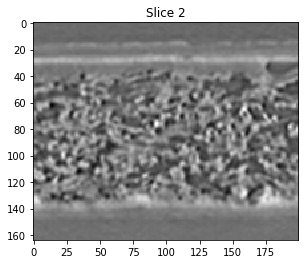

In [3]:
# Convert the stack of 2D slices to a 3D volume
vol = vol.concatenate().astype(np.int32)
vol = np.transpose(vol,(1,2,0)) # Re-order volume
print(vol.shape)

f,ax = plt.subplots()
ax.imshow(vol[..., 2], cmap='gray')
ax.set_title('Slice 2')
plt.show()

Like previously we want three segmentations in each slice of the volume. But due to the break in the top surface we intentionally make too many segmentations and then index.

**Notice** Making multiple segmentations on volumes can take a long time. The ```number_of_segmentations``` is therefore set to two but can be changed to a higher number to get that last segmentation.

In [4]:
number_of_segmentations = 2 # Change to 9

layers = []
for i in range(number_of_segmentations):
    layers.append(GraphObject(255-vol))

We create the ```MaxflowBuilder``` and add the layers. THen we add layered cost and smoothness as well as ```add_layered_containment```, which lets us specify a minimum and maximum distance between segmentations.

In [5]:
helper = MaxflowBuilder()
helper.add_objects(layers)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness()  

for i in range(len(layers)-1):
    helper.add_layered_containment(layers[i], layers[i+1], min_margin=10)

In [6]:
flow = helper.solve()
print('Maximum flow/minimum energy:', flow)

Maximum flow/minimum energy: 958474


In [7]:
segmentations = [helper.what_segments(l).astype(np.int32) for l in layers]
segmentation_lines = [np.argmin(s[..., 2], axis=0) for s in segmentations]

# Index segmentations
if len(segmentations) > 2:
    segmentations = [segmentations[i] for i in [0,-2,-1]]
    segmentation_lines = [segmentation_lines[i] for i in [0,-2,-1]]

The segmentations can then be visualized

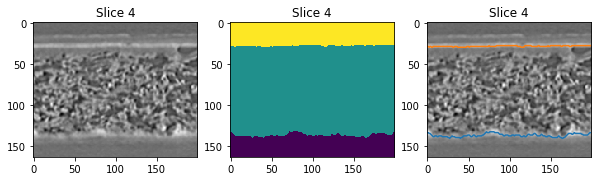

In [8]:
sliceNo = 4

f,ax = plt.subplots(1,3,figsize=(10,10))
ax[0].imshow(vol[..., 2], cmap='gray')
ax[0].set_title(f'Slice {sliceNo}')
ax[1].imshow(np.sum(segmentations, axis=0)[..., 2])
ax[1].set_title(f'Slice {sliceNo}')
ax[2].imshow(vol[..., 2], cmap='gray')
for line in segmentation_lines:
    ax[2].plot(line)
ax[2].set_title(f'Slice {sliceNo}')
plt.show()